# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Load Dataset

Untuk mengambil dataset dari kaggle kita harus uploud kaggle.json terlebih dahulu

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucascha","key":"6ee5fce662be883e09df2bfb406e4795"}'}

Pada tahap ini, dilakukan konfigurasi awal agar dapat mengunduh dataset langsung dari Kaggle menggunakan API. File `kaggle.json` berisi **API credentials (username dan key)** yang digunakan untuk mengautentikasi akun Kaggle pengguna.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Karena ketika download format datasetnya masi dalam zip kita lakukan unzip datasetnya

In [ ]:
# Download Bitcoin dataset
!kaggle datasets download -d mczielinski/bitcoin-historical-data
!unzip -o bitcoin-historical-data.zip

Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
 85% 80.0M/93.9M [00:00<00:00, 831MB/s]
100% 93.9M/93.9M [00:00<00:00, 754MB/s]
Archive:  bitcoin-historical-data.zip
  inflating: btcusd_1-min_data.csv   


Pada tahap ini, dataset harga historis Bitcoin dimuat ke dalam notebook menggunakan pandas. Data ini terdiri dari kolom seperti Timestamp, Open, High, Low, Close, dan Volume.

In [ ]:
df = pd.read_csv('btcusd_1-min_data.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


#  Exploratory Data Analysis (EDA)

In [ ]:
# Lihat ukuran dari dataset
print(df.shape)

(7032685, 6)


- Tahap ini Digunakan untuk mengetahui jumlah baris dan kolom dalam dataset. Hasil `(7032685, 6)` menunjukkan ada 7 juta lebih data dengan 6 fitur.


In [ ]:
# Melihat Info data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032685 entries, 0 to 7032684
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 321.9 MB
None


- Pada tahap Digunakan untuk menampilkan tipe data tiap kolom, jumlah entri, dan penggunaan memori. Hasil menunjukkan semua kolom bertipe `float64` dan total entri sebanyak 7.032.685 baris.

In [ ]:
# Tampilkan nilai null
print("\nCek nilai kosong:")
print(df.isnull().sum())


Cek nilai kosong:
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


- Langkah ini dilakukan untuk memastikan tidak ada data yang hilang pada setiap kolom. Hasilnya menunjukkan bahwa seluruh kolom tidak memiliki nilai kosong (null).

In [ ]:
# Tampilkan deskripsi data
print("Statistik deskriptif:")
df.describe()

Statistik deskriptif:


,Timestamp,Open,High,Low,Close,Volume
count,7.032685e+06,7.032685e+06,7.032685e+06,7.032685e+06,7.032685e+06,7.032685e+06
mean,1.536393e+09,1.766028e+04,1.766726e+04,1.765308e+04,1.766028e+04,5.288158e+00
std,1.218112e+08,2.445830e+04,2.446626e+04,2.445012e+04,2.445826e+04,2.248684e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.430902e+09,4.254800e+02,4.256600e+02,4.252600e+02,4.254800e+02,1.810000e-02
50%,1.536393e+09,6.630760e+03,6.634980e+03,6.626990e+03,6.630660e+03,4.653573e-01
75%,1.641883e+09,2.755000e+04,2.755500e+04,2.754400e+04,2.755000e+04,3.022468e+00
max,1.747443e+09,1.091110e+05,1.093560e+05,1.087940e+05,1.090360e+05,5.853852e+03


- Tahap ini Menampilkan ringkasan statistik untuk setiap kolom numerik, seperti nilai rata-rata (mean), standar deviasi (std), minimum, maksimum, serta kuartil (25%, 50%, 75%). Langkah ini membantu memahami sebaran dan rentang nilai pada data harga Bitcoin.

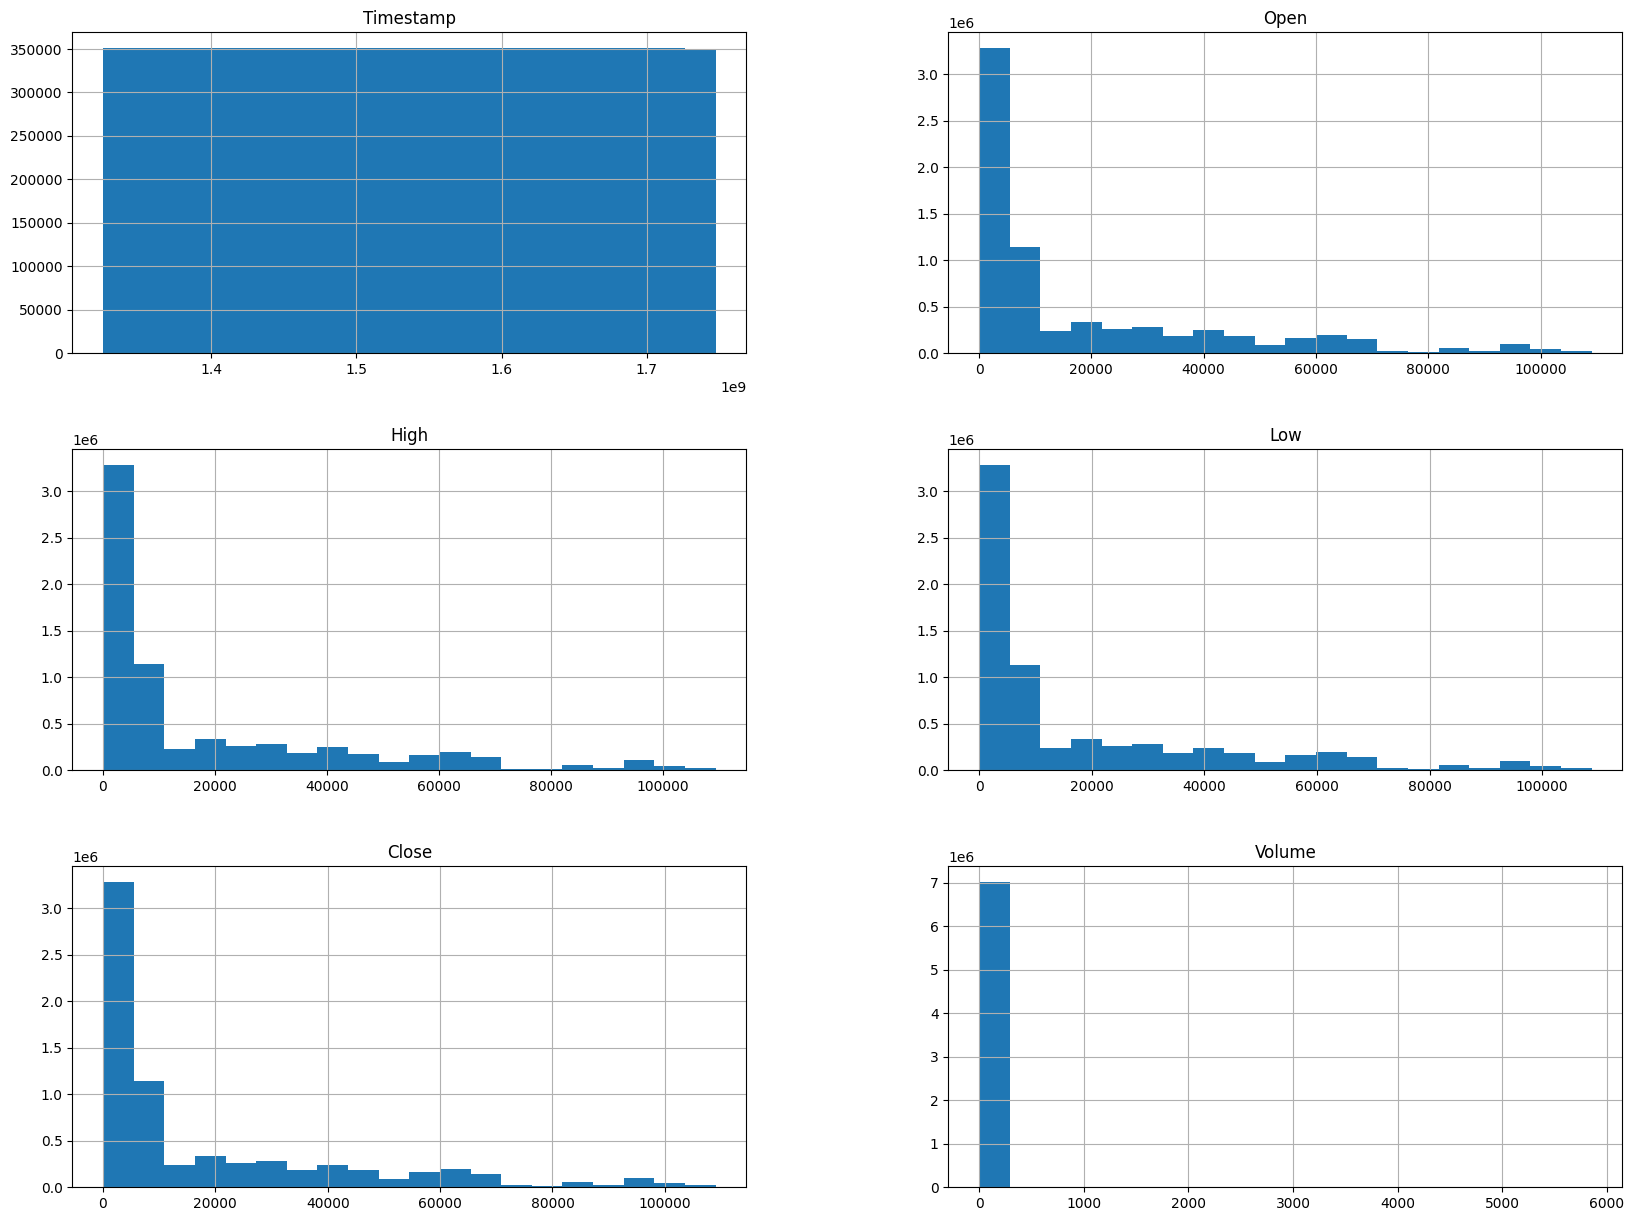

In [ ]:
df.hist(bins=20, legend=False, figsize=(20, 15))
plt.show()

- Langkah ini digunakan untuk menampilkan Plot histogram untuk setiap fitur numerik guna melihat distribusi nilai. Ini membantu mendeteksi pola umum, pencilan (outlier), dan sebaran data pada fitur seperti `Open`, `High`, `Low`, `Close`, dan `Volume`.

# Data Preprocessing

In [ ]:
# Menghapus nilai kosong
df.dropna(inplace=True)

- dropna digunakan untuk menghapus nilai kosong jika ada, tetapi dalam datset ini sendiri tidak ada nilai kosong

In [ ]:
# Ubah timestamp ke datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

- tahap ini digunakan untuk merubah nilai pada timestamp kedalam date time

In [ ]:
# Set index sebagai waktu
df.set_index('Timestamp', inplace=True)

- menetapkan kolom Timestamp sebagai index dari DataFrame.

In [ ]:
df = df.resample('1D').mean().dropna()

- resample('1D'): Mengelompokkan data berdasarkan interval 1 hari (daily).

- .mean(): Menghitung rata-rata dari setiap grup harian. Cocok jika data awalnya berdurasi lebih pendek, seperti per jam atau per menit.

- .dropna(): Menghapus baris yang mengandung nilai NaN setelah proses resampling (mungkin karena tidak ada data pada hari tertentu).

In [ ]:
df = df[['Close']]

- Setelah resampling, hanya kolom Close yang dipertahankan.

In [ ]:
# Normalisasi
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

- Pada bagian ini dilakukan normalisasi data dengan MinMaxScaler untuk mengubah skala fitur ke dalam rentang [0, 1]. Hal ini penting agar model deep learning dapat belajar secara optimal karena sensitivitas terhadap skala input.


In [ ]:
# Buat Time Series Dataset
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 60
X, y = create_sequences(scaled_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # [samples, timesteps, features]

- Membuat urutan data sepanjang n_steps (misal 60 hari) untuk memprediksi nilai berikutnya.
X: berisi urutan nilai sebelumnya.
y: berisi target nilai setelah urutan tersebut. kemudian reshape kebentuk 3 dimensi

In [ ]:
# Split Train & Test
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]
dates = df.index[n_steps:]
test_dates = dates[split:]

- Memisahkan data 80% untuk training (X_train, y_train), 20% untuk testing (X_test, y_test).

- test_dates: menyimpan tanggal yang sesuai untuk visualisasi hasil prediksi nanti.

In [ ]:
df.head()

,Close
Timestamp,
2012-01-01,4.645697
2012-01-02,4.975000
2012-01-03,5.085500
2012-01-04,5.170396
2012-01-05,5.954361


- lihat dataset setelah preprocessing

# Modelling

In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Sequential dengan 2 layer LSTM:
- LSTM pertama: return_sequences=True agar output cocok untuk LSTM berikutnya.
- LSTM kedua: output terakhir untuk prediksi.
- Dense(1): layer output dengan 1 neuron, memprediksi 1 nilai Close.

Optimizer: Adam, cepat dan efisien.

Loss: Mean Squared Error (MSE) cocok untuk regresi (angka kontinu).

In [ ]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0057 - val_loss: 0.0010
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 2.6167e-04 - val_loss: 0.0016
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 2.3714e-04 - val_loss: 0.0014
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 1.9758e-04 - val_loss: 0.0028
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 1.6435e-04 - val_loss: 0.0013
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.5836e-04 - val_loss: 0.0010


- EarlyStopping: hentikan training jika val_loss tidak membaik selama 5 epoch.
- validation_data: gunakan data test saat training untuk validasi.
- Training dilakukan selama max 20 epoch dengan batch_size=64.

In [ ]:
# Predict test set
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


- Model membuat prediksi terhadap data X_test.
- inverse_transform: mengembalikan nilai ke skala aslinya (karena sebelumnya dinormalisasi).
- y_pred_inv dan y_test_inv siap untuk evaluasi atau visualisasi.

# Evaluasi

In [ ]:
# Evaluate
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")

MAE  : 2322.14
RMSE : 3452.64
R²   : 0.98


Pada tahap ini kita melihat hasil evaluasi menggunakan beberapa metrik
- MAE (Mean Absolute Error): rata-rata selisih absolut antara prediksi dan nilai sebenarnya. Semakin kecil, semakin baik.
- RMSE (Root Mean Squared Error): mirip MAE tapi lebih sensitif terhadap error besar.
- R² (R-squared): mengukur seberapa baik model menjelaskan variasi data.Nilai R² mendekati 1 menandakan prediksi sangat baik.

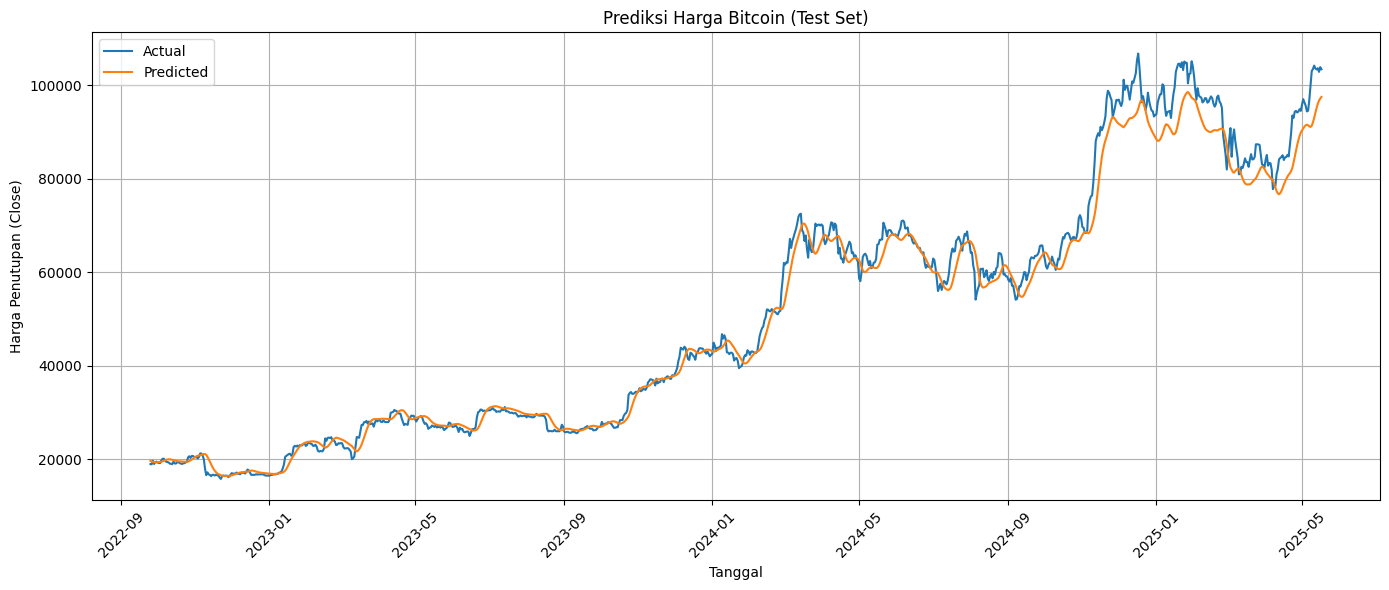

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_inv, label='Predicted')
plt.title('Prediksi Harga Bitcoin (Test Set)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (Close)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Pada tahap ini saya Membuat plot perbandingan antara nilai aktual (y_test_inv) dan hasil prediksi (y_pred_inv) terhadap tanggal (test_dates). Visual ini penting untuk melihat seberapa dekat prediksi mengikuti pola asli.

In [ ]:
# Forecast n_days ke depan
n_forecast = 7
last_sequence = scaled_data[-n_steps:].reshape(1, n_steps, 1)
future_preds = []

for _ in range(n_forecast):
    pred = model.predict(last_sequence)[0][0]
    future_preds.append(pred)
    last_sequence = np.append(last_sequence[:,1:,:], [[[pred]]], axis=1)

# Inverse transform hasil prediksi
future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


pada tahap ini kita ingin memprediksi harga 7 hari kedepan

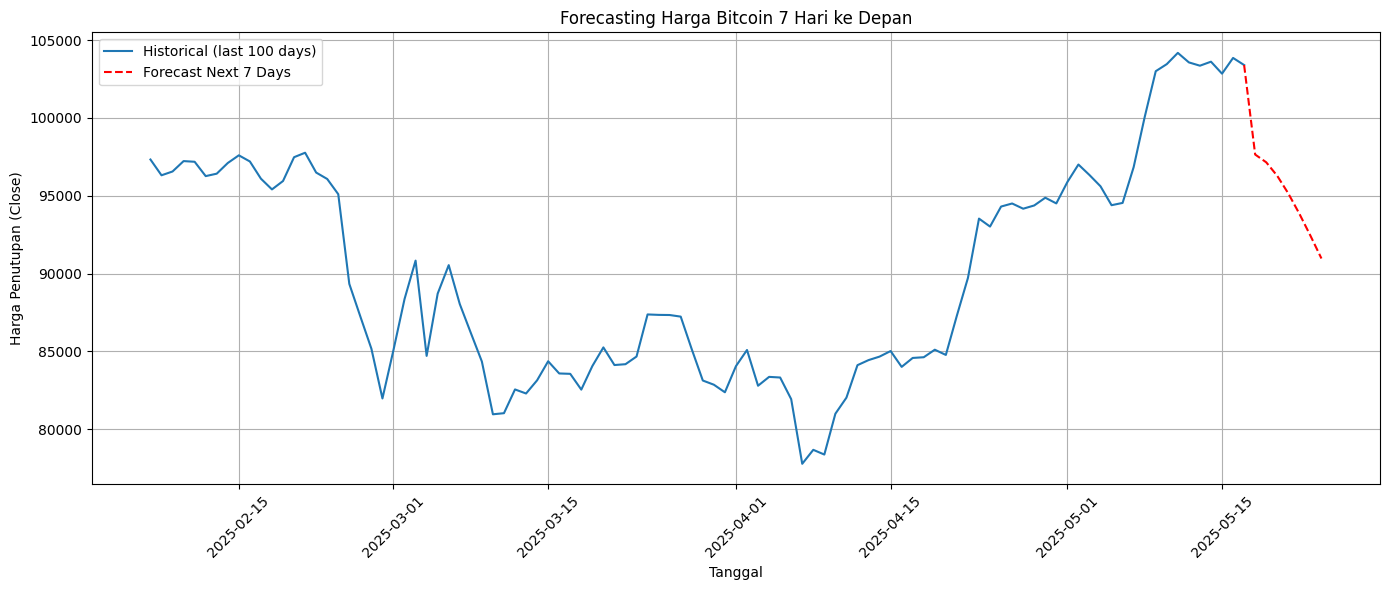

In [ ]:
# Ambil harga penutupan terakhir dari data historis
last_actual_date = df.index[-1]
last_actual_price = df['Close'].iloc[-1]

# Gabungkan titik akhir aktual dengan prediksi
forecast_dates = [last_actual_date] + list(future_dates)
forecast_prices = np.concatenate([[last_actual_price], future_preds_inv.flatten()])

# Visualisasi prediksi masa depan
plt.figure(figsize=(14,6))
plt.plot(df.index[-100:], df['Close'].values[-100:], label='Historical (last 100 days)')
plt.plot(forecast_dates, forecast_prices, label=f'Forecast Next {n_forecast} Days', linestyle='--', color='red')
plt.title(f'Forecasting Harga Bitcoin {n_forecast} Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (Close)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


dari grafik tersebut dapat dilihat bahwa
- Model prediksi berhasil menangkap pola harga sebelumnya (dengan R² = 0.98).
- Untuk jangka pendek, prediksi menunjukkan tren turun moderat.
- Visualisasi ini dapat membantu pengambilan keputusan untuk investor atau trader dalam waktu dekat.

Laporan Prediksi Harga Bitcoin 7 Hari ke Depan
=============================================

📌 Kesimpulan
-------------
Dari grafik "Forecasting Harga Bitcoin 7 Hari ke Depan", dapat disimpulkan bahwa:

- Harga Bitcoin diprediksi mengalami penurunan bertahap dalam 7 hari ke depan setelah puncaknya pada pertengahan Mei 2025.
- Tren historis 100 hari terakhir menunjukkan volatilitas harga yang cukup signifikan, dengan fase penurunan dan kenaikan tajam dalam kurun waktu pendek.
- Model dapat menangkap pola musiman dan tren naik-turun dalam harga, dan memproyeksikannya secara realistis untuk masa depan jangka pendek (7 hari).

📊 Evaluasi Model
-----------------
Model dievaluasi menggunakan tiga metrik utama:

- MAE  : 2.322,14
- RMSE : 3.452,64
- R²   : 0.98

Interpretasi:
- MAE menunjukkan rata-rata kesalahan prediksi terhadap nilai aktual. Nilai ini tergolong kecil.
- RMSE sedikit lebih besar karena penalti terhadap kesalahan besar, namun masih dalam batas wajar.
- R² sebesar 0.98 mengindikasikan bahwa model mampu menjelaskan 98% variasi pada data target, yang menunjukkan performa prediksi yang sangat baik.

✅ Kesimpulan Akhir
-------------------
Model LSTM yang digunakan memiliki performa yang sangat baik dalam memprediksi harga penutupan Bitcoin selama 7 hari ke depan. Dengan nilai R² sebesar 0.98 dan error yang rendah, model ini mampu memberikan prediksi yang cukup akurat.

Namun demikian, perlu diingat bahwa pasar kripto sangat volatil dan sensitif terhadap berbagai faktor eksternal. Maka dari itu, hasil prediksi ini sebaiknya digunakan sebagai referensi tambahan, bukan sebagai dasar utama dalam pengambilan keputusan investasi.
